In [1]:
import cv2
import pytesseract
import numpy as np
import imutils
import os
from ocr_plate import *
from keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [3]:
PATH = 'CarTGMT'
model_1_ac = load_model('my_Model.h5')
className = {"0":0,"1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7":7,"8":8,"9":9,"A":10,"B":11,"C":12,"D":13,"E":14,"F":15,"G":16,"H":17,"I":18,"J":19,"K":20,"L":21,"M":22,"N":23,"O":24,"P":25,"Q":26,"R":27,"S":28,"T":29,"U":30,"V":31,"W":32,"X":33,"Y":34,"Z":35}

In [4]:
new_key = list(className.keys())
new_val = list(className.values())

In [5]:
print(new_key[10:13])
print(new_val[10:13])

['A', 'B', 'C']
[10, 11, 12]


In [6]:
def cleanup_text(text):
    # Nối character trên biển số xe
    return "".join([text[i] for i in range(len(text)) ])

def preProcessing(img): 
    img = cv2.equalizeHist(img)
    img = img/255
    return img

def get_contour_precedence(contour, cols):
    tolerance_factor = 10
    origin = cv2.boundingRect(contour)
    return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

In [7]:
def getLine(pos):
    return pos[4]
def getWid(pos):
    return pos[0]


def removeNoise(pos):
    a = []
    p = pos.copy()
    for i in p:
        for j in p:
            if np.array_equal(i,j):
                continue
            else:
                if j[0] <= i[0] <= (j[0] +j[2])  and j[1] <= i[1] <= (j[1] + j[3]):
                    a = [k.tolist() for k in pos if not np.array_equal(k,i)]
    if len(a) == 0:
        return pos
    return np.array(a)

def setLine(pos):
    p = []
    height = np.min(pos[:,1]) + np.max(pos[:,3])
    for i in pos:
        if i[1]> height:
            i = i.tolist()
            i.append('l2')
        else:
            i = i.tolist()
            i.append('l1')
        p.append(i)
    return p

In [8]:
df = pd.read_csv('_report.csv')

In [9]:
df.head(5)

,AEONTP_5026788_checkin_2020-1-13-16-19_f7zXETONv.jpg,x,50Z6788
0,AEONTP_51F86947_checkin_2020-1-13-16-15sUVxP1I...,NaN,NaN
1,AEONTP_56P6961_checkin_2020-1-13-16-18chzYQvbl...,x,56P69611
2,AEONTP_62A02636_checkin_2020-1-13-16-14gXI_gF3...,NaN,NaN
3,AEONTP_6A00530_checkin_2020-1-13-16-16i7h_Z3Ua...,x,51A 005.30
4,AEONTP_6S81U5_checkin_2020-1-13-16-18bx9UOV6rY...,NaN,NaN


In [10]:
df = df.drop(columns=['x'])


In [11]:
df.head(10)

,AEONTP_5026788_checkin_2020-1-13-16-19_f7zXETONv.jpg,50Z6788
0,AEONTP_51F86947_checkin_2020-1-13-16-15sUVxP1I...,NaN
1,AEONTP_56P6961_checkin_2020-1-13-16-18chzYQvbl...,56P69611
2,AEONTP_62A02636_checkin_2020-1-13-16-14gXI_gF3...,NaN
3,AEONTP_6A00530_checkin_2020-1-13-16-16i7h_Z3Ua...,51A 005.30
4,AEONTP_6S81U5_checkin_2020-1-13-16-18bx9UOV6rY...,NaN
5,AQUA1_17054_checkin_2020-10-23-10-17jwhBJ7kzC_...,29H 170.54
6,AQUA1_25697_checkin_2020-10-23-8-17cJpC9WhKCt.jpg,20F 256.97
7,AQUA1_25697_checkin_2020-10-23-8-53U3VaS26nFf.jpg,NaN
8,AQUA1_33928_checkin_2020-10-23-8-46Pi5S8mEXah.jpg,29A 339.28
9,AQUA1_33928_checkin_2020-10-23-8-51ICUxEIQDLw.jpg,29A 339.28


In [12]:
df = df.dropna()
df.head(10)

,AEONTP_5026788_checkin_2020-1-13-16-19_f7zXETONv.jpg,50Z6788
1,AEONTP_56P6961_checkin_2020-1-13-16-18chzYQvbl...,56P69611
3,AEONTP_6A00530_checkin_2020-1-13-16-16i7h_Z3Ua...,51A 005.30
5,AQUA1_17054_checkin_2020-10-23-10-17jwhBJ7kzC_...,29H 170.54
6,AQUA1_25697_checkin_2020-10-23-8-17cJpC9WhKCt.jpg,20F 256.97
8,AQUA1_33928_checkin_2020-10-23-8-46Pi5S8mEXah.jpg,29A 339.28
9,AQUA1_33928_checkin_2020-10-23-8-51ICUxEIQDLw.jpg,29A 339.28
10,AQUA1_40304_checkin_2020-10-25-12-277bdC7U4qUk...,0L0304
11,AQUA1_43502_checkin_2020-10-23-8-17ifoUU8ftDr.jpg,30E 435.02
12,AQUA1_43502_checkin_2020-10-23-8-52NVGEHEXUkc.jpg,30E 435.02
14,AQUA1_46294_checkin_2020-10-23-8-19UnQ54DsL8f.jpg,29A 462.94


In [76]:
names = np.array(df.iloc[:,0]).tolist()
labels = np.array(df.iloc[:,1]).tolist()

In [77]:
print(names[:3])
print(labels[:3])

['AEONTP_56P6961_checkin_2020-1-13-16-18chzYQvblhX.jpg', 'AEONTP_6A00530_checkin_2020-1-13-16-16i7h_Z3Ua0Y.jpg', 'AQUA1_17054_checkin_2020-10-23-10-17jwhBJ7kzC_.jpg']
['56P69611', '51A 005.30', '29H 170.54']


In [78]:
print(len(labels))
print(len(names))

474
474


In [79]:
for l in range(len(labels)):
    labels[l] = labels[l].strip().replace(' ','').replace('.','')
print(labels[:5])

['56P69611', '51A00530', '29H17054', '20F25697', '29A33928']


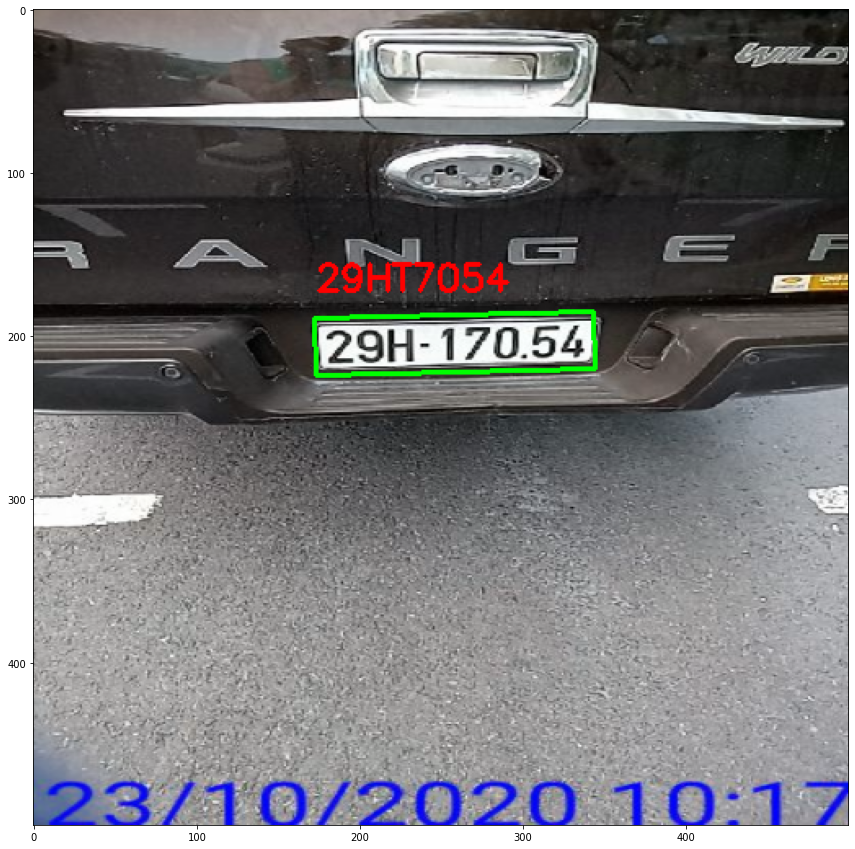

In [33]:
img = cv2.imread(PATH+"/"+names.iloc[2])
img = cv2.resize(img,(500,500),cv2.INTER_AREA)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
(pic, lpCnt) = ocr(gray)

if pic is not None and lpCnt is not None:
    position = []
    imgBox = pic.copy()
    imgBox = cv2.threshold(pic, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    imgBox = cv2.dilate(imgBox,None,iterations=1)
    pred = []
    cnts = cv2.findContours(imgBox.copy(), cv2.RETR_TREE,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:15]
    cnts = sorted(cnts,key=lambda x:get_contour_precedence(x, imgBox.shape[1]))


    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c) 
        ar = float(h/w)
        if h >= 70:
            position.append([x,y,w,h])
    if len(position) > 0:
        position = np.array(position)
        position = removeNoise(position)
        position = setLine(position)
        isLine = True
        for i in position:
            if i[4] == 'l2':
                isLine = False
                break
        if isLine:
            position.sort(key=getWid)
        else:
            position.sort(key=getLine)
        for c in position:
            char = pic[c[1]:c[1] + c[3] , c[0]  :c[0] + c[2]  ]
            char = cv2.threshold(char, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            imgBox = cv2.erode(imgBox,None,iterations=1)
            char = cv2.resize(char, (18, 18),cv2.INTER_AREA)
            mask = np.full((28,28),255,np.uint8)
            mask[5:23,5:23] = char[:,:] 
            char = mask.reshape(-1,mask.shape[0],mask.shape[1],1)
            classIndex = np.argmax(model.predict(char), axis=-1)[0]
            pred.append(new_key[new_val.index(classIndex)])

    box = cv2.boxPoints(cv2.minAreaRect(lpCnt))
    box = box.astype("int")
    cv2.drawContours(img, [box], -1, (0, 255, 0), 2)

    (x, y, w, h) = cv2.boundingRect(lpCnt)
    cv2.putText(img, cleanup_text(pred), (x, y - 15),
        cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2)
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.show()
    

In [80]:
imageList = os.listdir(PATH)
prediction = []

for i,index in enumerate(names):
    if index not in imageList:
        names = np.delete(names,i)
        labels = np.delete(labels,i)
    else:
        img = cv2.imread(PATH+"/"+index)

        img = cv2.resize(img,(500,500),cv2.INTER_AREA)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        (pic, lpCnt) = ocr(gray)
        pred = []
        if pic is not None and lpCnt is not None:
            position = []
            imgBox = pic.copy()
            imgBox = cv2.threshold(pic, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
            imgBox = cv2.dilate(imgBox,None,iterations=1)
            
            cnts = cv2.findContours(imgBox.copy(), cv2.RETR_TREE,
            cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:15]
            cnts = sorted(cnts,key=lambda x:get_contour_precedence(x, imgBox.shape[1]))


            for c in cnts:
                (x, y, w, h) = cv2.boundingRect(c) 
                ar = float(h/w)
                if h >= 70:
                    position.append([x,y,w,h])
            if len(position) > 0:
                position = np.array(position)
                position = removeNoise(position)
                position = setLine(position)
                isLine = True
                for i in position:
                    if i[4] == 'l2':
                        isLine = False
                        break
                if isLine:
                    position.sort(key=getWid)
                else:
                    position.sort(key=getLine)

                for c in position:
                    char = pic[c[1]:c[1] + c[3] , c[0]  :c[0] + c[2]  ]
                    char = cv2.threshold(char, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
                    imgBox = cv2.erode(imgBox,None,iterations=1)
                    char = cv2.resize(char, (18, 18),cv2.INTER_AREA)
                    mask = np.full((28,28),255,np.uint8)
                    mask[5:23,5:23] = char[:,:] 
                    char = mask.reshape(-1,mask.shape[0],mask.shape[1],1)
                    classIndex = np.argmax(model.predict(char), axis=-1)[0]
                    pred.append(new_key[new_val.index(classIndex)])

        prediction.append(cleanup_text(pred))
        
        


In [81]:
index = [p for p in range(len(prediction)) if len(prediction[p]) != len(labels[p])]
labels = np.delete(labels,index)
prediction = np.delete(prediction,index)

In [82]:
from sklearn.metrics import classification_report
score = classification_report(prediction,labels)
print(score)

              precision    recall  f1-score   support

    047920U0       0.00      0.00      0.00         1
    100E+244       0.00      0.00      0.00         0
    14A25074       0.00      0.00      0.00         1
     1500635       0.00      0.00      0.00         0
    15A00635       0.00      0.00      0.00         0
     15A0065       0.00      0.00      0.00         1
    15A02343       0.00      0.00      0.00         0
    15F58947       0.00      0.00      0.00         0
    18A07826       0.00      0.00      0.00         0
    19D21S98       0.00      0.00      0.00         0
    1DA90296       0.00      0.00      0.00         0
    1DE19752       0.00      0.00      0.00         0
    1DP92619       0.00      0.00      0.00         0
    1UA25074       0.00      0.00      0.00         0
    20DE1171       0.00      0.00      0.00         0
    20F25697       0.00      0.00      0.00         0
     2122443       0.00      0.00      0.00         1
     256E+04       0.00    

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [83]:
pair = [[prediction[i][j],labels[i][j]] for i in range(len(prediction)) for j in range(len(prediction[i]))]

In [87]:
pair = np.array(pair)

In [88]:
print(pair[:15])

[['2' '2']
 ['9' '9']
 ['H' 'H']
 ['T' '1']
 ['7' '7']
 ['0' '0']
 ['5' '5']
 ['4' '4']
 ['5' '2']
 ['0' '0']
 ['F' 'F']
 ['2' '2']
 ['5' '5']
 ['5' '6']
 ['P' '9']]


In [89]:

print(classification_report(pair[:,0],pair[:,1]))

              precision    recall  f1-score   support

           +       0.00      0.00      0.00         0
           0       0.73      0.61      0.66       109
           1       0.12      0.25      0.16        28
           2       0.63      0.78      0.70        79
           3       0.42      0.73      0.53        56
           4       0.79      0.54      0.64        63
           5       0.68      0.29      0.41       137
           6       0.64      0.71      0.67        48
           7       0.57      0.47      0.51        60
           8       0.18      0.53      0.27        17
           9       0.52      0.48      0.50        95
           A       0.54      0.64      0.59        39
           B       0.00      0.00      0.00         2
           C       0.00      0.00      0.00         4
           D       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         0
           F       0.18      0.22      0.20         9
           G       0.09    

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [23]:
import tensorflow as tf
from sklearn. model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import  to_categorical
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn import datasets

In [122]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

def myModel2(noofClasses,los,ac):

    #Nhận input đầu vào gồm số các label khác nhau

    model = Sequential()
    model.add(LSTM(units=100,activation='relu', input_shape=(28,28), return_sequences=True))
    model.add(Dropout(0.25))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.25))

    model.add(LSTM(units=50))
    model.add(Dense(noofClasses, activation='softmax'))
    #đầu ra là mô hình gồm 36 label đã khởi tạo
    model.compile(optimizer='adam', loss=los,metrics=[ac])

  
    return model


In [90]:
path = 'Images/'
#Đọc từng dữ liệu ảnh trong folder Images
images = []
classNo = []
folders = os.listdir(path)
for folder in folders:
    f = os.listdir(path+folder)
    for x in f:
        lisPic = os.listdir(path+folder+"/"+x)
        for img in lisPic:
            #Đọc file image với đường dẫn
            curImg = cv2.imread(path+folder+"/"+x+"/"+img)
            #Resize ảnh thành ảnh kích thước chuẩn 28
            curImg = cv2.resize(curImg, (28, 28),cv2.INTER_AREA)
            # đổi ảnh thành ảnh màu xám để xử lý dữ liệu
            curImg = cv2.cvtColor(curImg,cv2.COLOR_BGR2GRAY)
            # Format hình ảnh alphabet chuẩn theo threshhold với nền trắng và dữ liệu đen
            if folder == "character":
                curImg = cv2.threshold(curImg, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

            # Thêm ảnh vào mảng
            images.append(curImg)
            # Gán label ảnh đó theo đúng tên kí tự của folder ảnh đó
            classNo.append(x)

In [91]:
images = np.array(images)
classNo = np.array(classNo)

print(len(images))
print(len(classNo))

#fit label ảnh thành dạng số
le = LabelEncoder()
label = classNo
classNo = le.fit_transform(classNo)

638913
638913


In [92]:
#tách dữ liệu train 80%, test 20%
X_train,X_test, y_train,y_test = train_test_split(images,classNo, test_size=0.2)

#tách tiếp dữ liệu train thành 80%, validation 20% (train 60%, validation 20%, test 20%)
X_train,X_validation, y_train,y_validation = train_test_split(X_train,y_train, test_size=0.2)

In [119]:
#lấy các ảnh của 3 tập dữ liệu để xử lý cân bằng hình ảnh
X_train= np.array(list(map(preProcessing, X_train)))
X_test= np.array(list (map(preProcessing,X_test)))
X_validation= np.array(list(map(preProcessing, X_validation)))


#REshape 3 tập dữ liệu thành đúng dạng tổng size dữ liệu, size ảnh
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],
                                    X_validation.shape[2],1)

In [118]:
print(X_validation.shape)

(102226, 28, 28, 1)


In [95]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                              height_shift_range=0.1,
                              zoom_range=0.1,
                              shear_range=0.1,
                              rotation_range=10,
                              horizontal_flip=True)
#fit dataGen vào tập X_train
dataGen.fit(X_train)

In [96]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_validation = to_categorical(y_validation)

In [123]:
#lấy model từ model2
model = myModel2(36,'categorical_crossentropy','accuracy')
#in ra thông số của model
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 28, 100)           51600     
_________________________________________________________________
dropout_10 (Dropout)         (None, 28, 100)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 28, 50)            30200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 28, 50)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 36)                1836      
Total params: 103,836
Trainable params: 103,836
Non-trainable params: 0
_______________________________________________

In [127]:
batchSizeVal= 50
epochsVal = 10
stepsPerEpochVal = 100
#train model với tập X_train vs y_train với fit với tập validation 
history = model.fit_generator(dataGen.flow(X_train,y_train,
                                  batch_size=batchSizeVal),
                                  epochs=epochsVal,
                                  steps_per_epoch=stepsPerEpochVal,
                                  validation_data=(X_validation, y_validation),
                                  shuffle=1)

#Dự đoán mô hình với tập test
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])
X_test = X_test[:300000]
y_test = y_test.reshape(y_test.shape[0],y_test.shape[1],y_test.shape[2])
y_test = y_test[:300000]
print(X_test.shape)
score = model.evaluate((X_test,y_test), verbose=0) 
print('Test Score = ',score[0]) 
print('Test Accuracy =', score[1])
#Độ chính xác mô hình
#Lưu mô hình dạng h5 để sử dụng, ko cần phải train lại tốn thời gian	
model.save("my_Model2.h5")

Epoch 1/10


ValueError: in user code:

    c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:830 train_function  *
        return step_function(self, iterator)
    c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:813 run_step  *
        outputs = model.train_step(data)
    c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:770 train_step  *
        y_pred = self(x, training=True)
    c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py:989 __call__  *
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\keras\engine\input_spec.py:212 assert_input_compatibility  *
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_10 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, None, None, None)


In [ ]:
accuracy_1 = scaler.inverse_transform(test_output)
accuracy_2 = scaler.inverse_transform(y_test)
plt.plot(test_1[:100], color='r')
plt.plot(test_2[:100] ,color='b')
plt.title("ACCURACY")
plt.legend(('accuracy_lstm', 'accuaracy_conv2D'),loc='upper right')
plt.show()